In [17]:
# List all file in data directory with Pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import img_to_array

LABELS_DICT = {"control":0, "sick":1}
SUB_FOLDERS = ["control", "sick"]

def get_mouse_model(file_path):
  file_name = file_path.split("/")[-1]
  if "wt" in file_name.lower():
    return "wt"
  elif "bin1" in file_name.lower():
    return "bin1"
  elif "dnm2" in file_name.lower():
    return "dnm2"
  else:
    return "unknown"

def dirty_filter_file_names(file_name):
    file_name = file_name.split("/")[-1]
    file_name = '_'.join(file_name.split("_")[:-1])
    file_name = '_'.join(file_name.split("_")[1:])
    file_name = '_'.join(file_name.split("_")[:-1])
    file_name = ''.join(file_name.split("_SDH -")[0])
    file_name = '_'.join(file_name.split("_")[1:])
    return file_name

def generate_dataset(folder, sub_folders=["control", "inter", "sick"]):
    n_elem = 0
    for sub_folder in sub_folders:
      n_elem += len(glob.glob(os.path.join(folder, sub_folder, "*.tif")))
    images_array = np.empty(shape=(n_elem, 256, 256, 3), dtype=np.uint8)
    path_array = []
    mouse_model = []
    mouse_model_full = []
    labels_array = np.empty(shape=n_elem, dtype=np.uint8)
    counter = 0
    for index, sub_folder in enumerate(sub_folders):
      path_files = os.path.join(folder, sub_folder, "*.tif")
      for img in glob.glob(path_files):
          im = img_to_array(image.load_img(img))
          # im_resized = image.smart_resize(im, (256, 256)) 
          path_array.append(img)
          mouse_model.append(get_mouse_model(img))
          mouse_model_full.append(dirty_filter_file_names(img))
          images_array[counter] = tf.image.resize(im, (256,256))
          labels_array[counter] = index
          counter += 1
    return images_array, path_array, labels_array, mouse_model, mouse_model_full

img_data, all_files, labels, mouse_model, mouse_model_full = generate_dataset("data/all_images", sub_folders=SUB_FOLDERS)
file_dict = dict(
    file=all_files,
    label=labels,
    image=img_data, model=mouse_model, model_full=mouse_model_full)

2023-01-30 15:52:12.968239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-30 15:52:13.194644: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-30 15:52:14.247618: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-30 15:52:14.247803: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [16]:
import glob



# a = glob.glob("data/all_images/**/*.tif", recursive=True)
# a = [x.split("/")[-1] for x in a]
# a = ['_'.join(x.split("_")[:-1]) for x in a]
# a = ['_'.join(x.split("_")[1:]) for x in a]
# a = ['_'.join(x.split("_")[:-1]) for x in a]
# a = [''.join(x.split("_SDH -")[0]) for x in a]
# a = ['_'.join(x.split("_")[1:]) for x in a]
# set(a)

{'BIN1_KO_AAV_EMPTY_TAG',
 'BIN1_KO_AAV_MTM1_TAD',
 'BIN1_WT_AAV_EMPTY_TAG',
 'SDH_TAM_Bin1cKO_ko_pla',
 'SDH_TAM_Dnm2S619L_sl_pla',
 'SDH_TAM_Dnm2S619L_sl_tam'}

In [ ]:
from embetter.vision import ImageLoader, TimmEncoder
from sklearn.pipeline import make_pipeline 
import numpy as np

image_emb_pipeline = make_pipeline(
  ImageLoader(convert="RGB"),
  TimmEncoder("mobilenetv2_120d")
)
embedding = image_emb_pipeline.fit_transform(all_files)
with open('data/results/embedding/image_embedding.npy', 'wb') as f:
    np.save(f, embedding)

In [18]:
from umap import UMAP
import numpy as np
embedding = np.load(open('data/results/embedding/image_embedding.npy', 'rb'))
embedding_umap = UMAP().fit_transform(embedding)
embedding_umap.shape

(16787, 2)

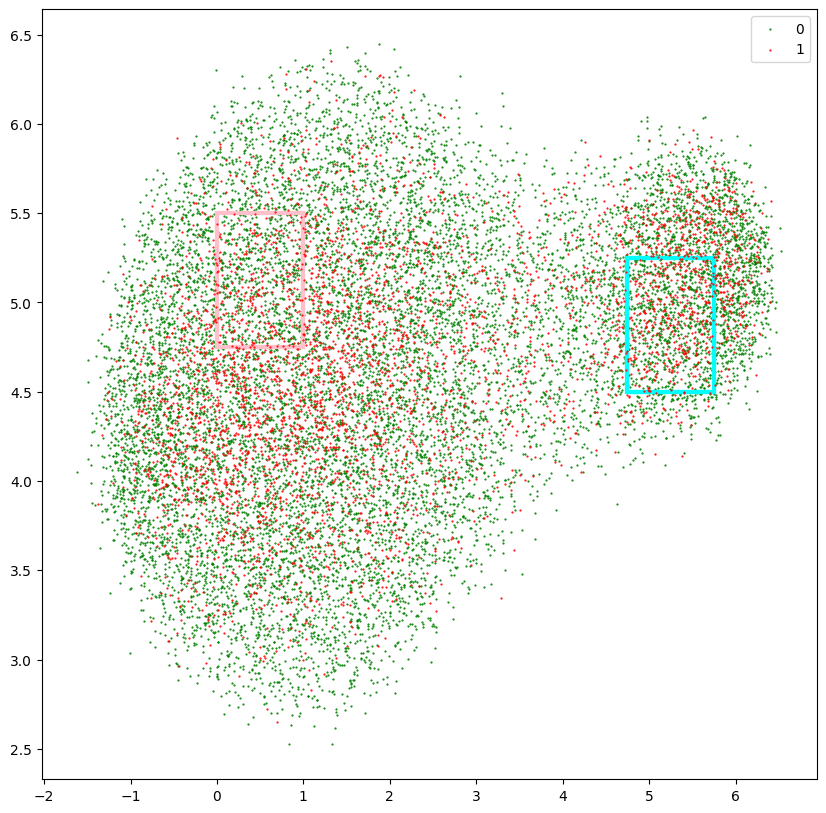

In [20]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
cdict = {0: 'green', 1: 'red'}

# Get the index of row from embedding_umap where the first column is greater than 0 and the second column is greater than 0

x_condition2 = ((embedding_umap[:,0] > 0) & (embedding_umap[:,0] < 1))
y_condition2 = ((embedding_umap[:,1] > 4.75) & (embedding_umap[:,1] < 5.5))
idx_left_cluster = np.where((x_condition2 & y_condition2))[0]

x_condition = ((embedding_umap[:,0] > 4.75) & (embedding_umap[:,0] < 5.75))
y_condition = ((embedding_umap[:,1] > 4.5) & (embedding_umap[:,1] < 5.25))
idx_right_cluster = np.where((x_condition & y_condition))[0]

fig, ax = plt.subplots(1, 1, figsize=(10,10))
for g in np.unique(labels):
    ix = np.where(labels == g)
    ax.add_patch(Rectangle((0, 4.75), 1, 0.75,
             edgecolor = 'pink',
             facecolor = 'blue',
             fill=False,
             lw=3))
    ax.add_patch(Rectangle((4.75, 4.5), 1, 0.75,
             edgecolor = 'cyan',
             facecolor = 'blue',
             fill=False,
             lw=3))
    ax.scatter(embedding_umap[:, 0][ix], 
                embedding_umap[:, 1][ix], 
                s=0.3, 
                c=cdict[g],
                label=g)
ax.legend()
plt.show()

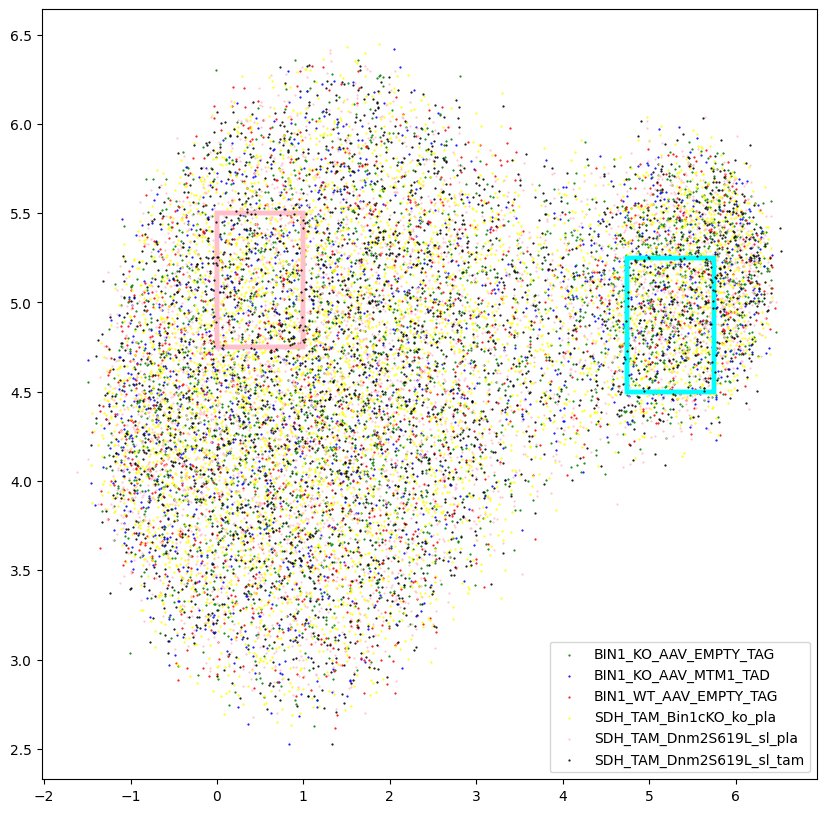

In [21]:
cdict_model_full = {'BIN1_KO_AAV_EMPTY_TAG':"green",
 'BIN1_KO_AAV_MTM1_TAD':"blue",
 'BIN1_WT_AAV_EMPTY_TAG':"red",
 'SDH_TAM_Bin1cKO_ko_pla':"yellow",
 'SDH_TAM_Dnm2S619L_sl_pla':"pink",
 'SDH_TAM_Dnm2S619L_sl_tam':"black"}
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for g in np.unique(mouse_model_full):
    numpy_mouse_model_full = np.array(mouse_model_full)
    ix = np.where(numpy_mouse_model_full == g)
    ax.add_patch(Rectangle((0, 4.75), 1, 0.75,
             edgecolor = 'pink',
             facecolor = 'blue',
             fill=False,
             lw=3))
    ax.add_patch(Rectangle((4.75, 4.5), 1, 0.75,
             edgecolor = 'cyan',
             facecolor = 'blue',
             fill=False,
             lw=3))
    ax.scatter(embedding_umap[:, 0][ix], 
                embedding_umap[:, 1][ix], 
                s=0.3, 
                c=cdict_model_full[g],
                label=g)
ax.legend()
plt.show()

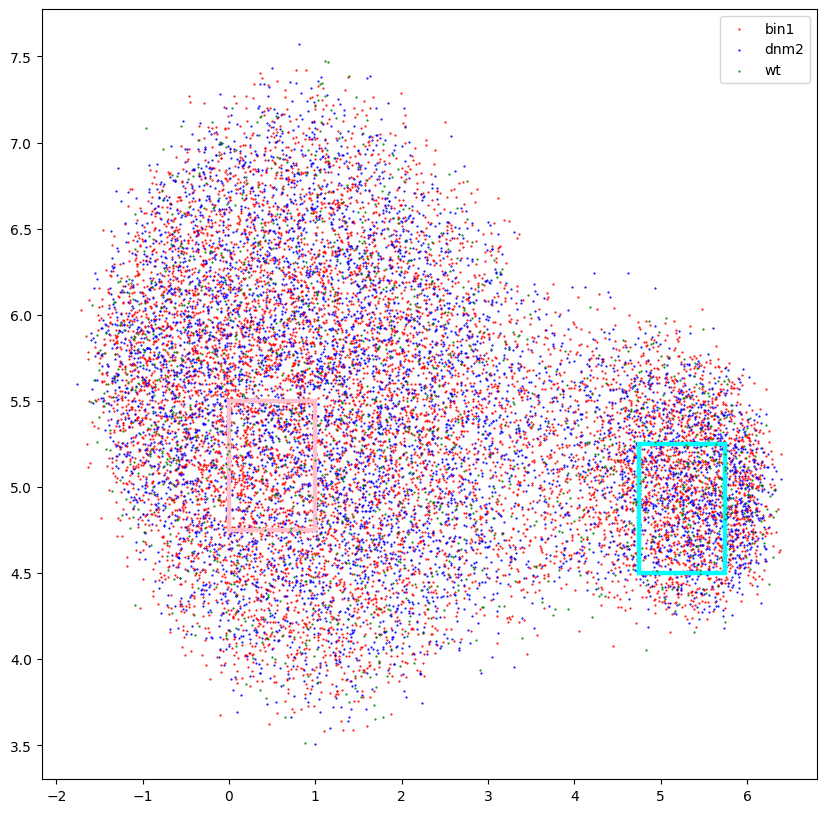

In [16]:
cdict_model = {"wt": 'green', "bin1": 'red', "dnm2": "blue", "unknown": "black"}
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for g in np.unique(mouse_model):
    numpy_mouse_model = np.array(mouse_model)
    ix = np.where(numpy_mouse_model == g)
    ax.add_patch(Rectangle((0, 4.75), 1, 0.75,
             edgecolor = 'pink',
             facecolor = 'blue',
             fill=False,
             lw=3))
    ax.add_patch(Rectangle((4.75, 4.5), 1, 0.75,
             edgecolor = 'cyan',
             facecolor = 'blue',
             fill=False,
             lw=3))
    ax.scatter(embedding_umap[:, 0][ix], 
                embedding_umap[:, 1][ix], 
                s=0.3, 
                c=cdict_model[g],
                label=g)
ax.legend()
plt.show()

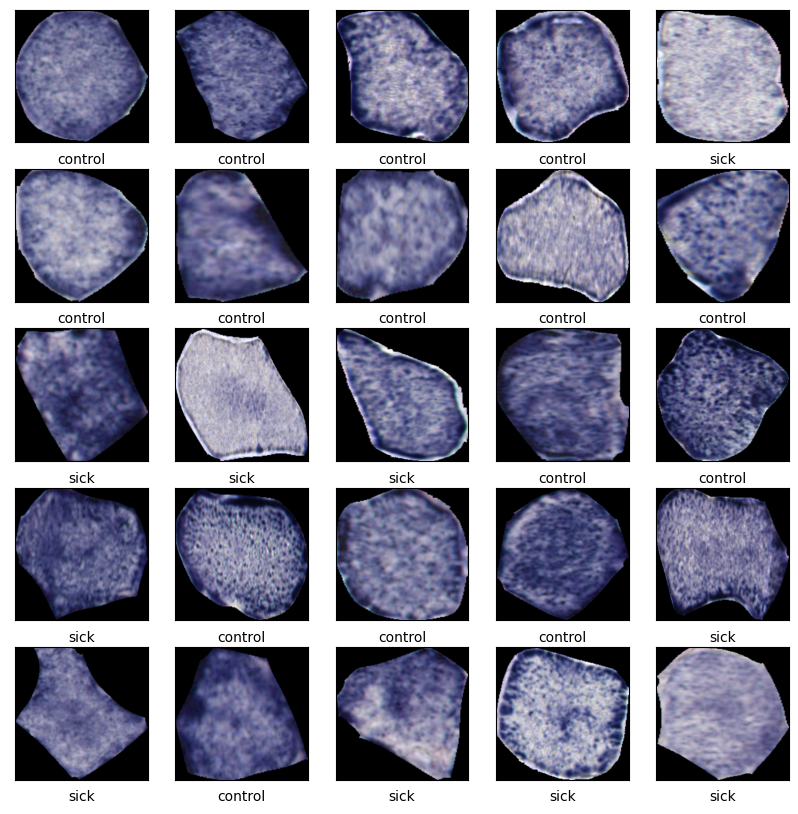

In [28]:
import imageio.v3 as imageio
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

SUB_FOLDERS = ["control", "sick"]
counter = 0
plt.figure(figsize=(10,10))

for idx in np.random.choice(idx_right_cluster, 25, replace=False):
    plt.subplot(5,5,counter+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    path_to_img = all_files[idx]
    im = imageio.imread(path_to_img)
    im_resized = tf.image.resize(im, (256,256))
    plt.imshow(im_resized.astype(np.uint8))
    plt.xlabel(SUB_FOLDERS[labels[idx]])
    counter +=1
plt.show()


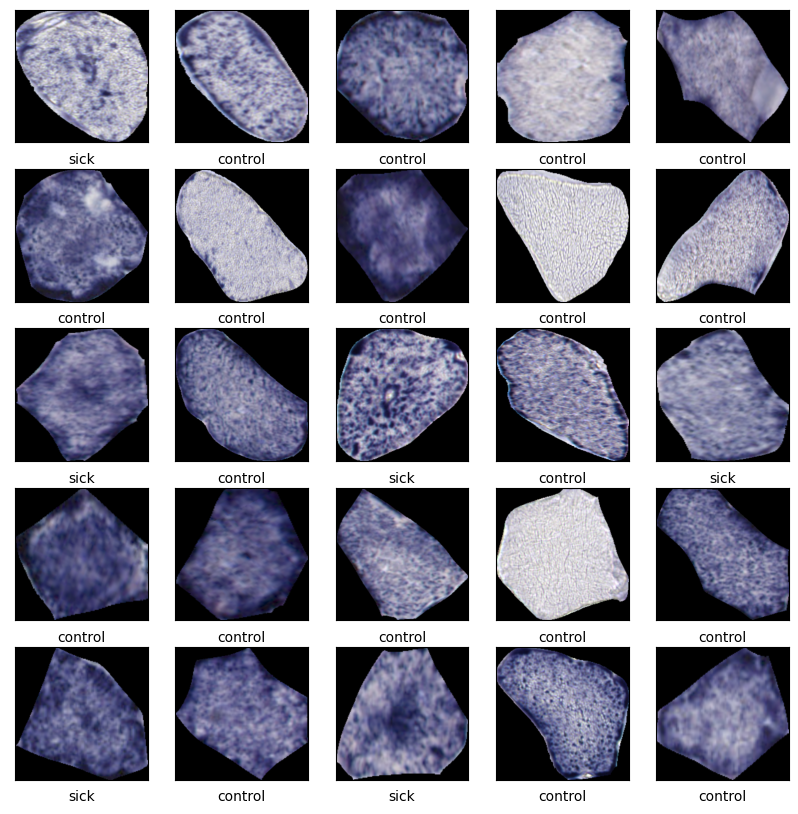

In [27]:
import imageio.v3 as imageio
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()


counter = 0
plt.figure(figsize=(10,10))

for idx in np.random.choice(idx_left_cluster, 25, replace=False):
    plt.subplot(5,5,counter+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    path_to_img = all_files[idx]
    im = imageio.imread(path_to_img)
    im_resized = tf.image.resize(im, (256,256))
    plt.imshow(im_resized.astype(np.uint8))
    plt.xlabel(SUB_FOLDERS[labels[idx]])
    counter +=1
plt.show()


In [29]:
def generate_dataset(folder, sub_folders=["control", "inter", "sick"]):
    n_elem = 0
    for sub_folder in sub_folders:
      n_elem += len(glob.glob(os.path.join(folder, sub_folder, "*.tif")))
    
    images_array = np.empty(shape=(n_elem, 256, 256, 3), dtype=np.uint8)
    labels_array = np.empty(shape=n_elem, dtype=np.uint8)
    counter = 0
    for index, sub_folder in enumerate(sub_folders):
      path_files = os.path.join(folder, sub_folder, "*.tif")
      for img in glob.glob(path_files):
          im = img_to_array(image.load_img(img))
          # im_resized = image.smart_resize(im, (256, 256))
          im_resized = tf.image.resize(im, (256,256))
          images_array[counter] = im_resized
          labels_array[counter] = index
          counter += 1
    return images_array, labels_array
train_images, train_labels = generate_dataset(os.path.join("data", "train"), sub_folders=["control","sick"])
test_images, test_labels = generate_dataset(os.path.join("data", "test"), sub_folders=["control","sick"])
# Load tensorflow model
model = tf.keras.models.load_model('data/results/SDH16K_GPU_WITHAUG/model.h5')

In [63]:
from doubtlab.ensemble import DoubtEnsemble
from doubtlab.reason import ProbaReason, LongConfidenceReason , WrongPredictionReason, CleanlabReason
import pandas as pd 

# Let's precalculate the proba values.
probas = model.predict(img_data)
predicted_class = np.argmax(probas, axis=1)
# We can re-use the probas below. Note that some reasons require extra information.
# Also beware that `y` and `probas` are globals now! 
predicate_dict = dict(
    proba=ProbaReason.from_proba(probas, max_proba=0.6),
    long=LongConfidenceReason.from_proba(probas, labels, classes=set(labels), threshold=0.85),
    wrong=WrongPredictionReason.from_predict(predicted_class, labels),
    cleanlab=CleanlabReason.from_proba(probas, labels),
)

# This dataframe now contains the predicates
doubtlab_df = pd.DataFrame(predicate_dict)
# Create a new column with 1 if the previous predicates are true else 0
doubtlab_df['doubt'] = doubtlab_df[["proba","long","wrong","cleanlab"]].ne(0).any(axis=1)
wrong_strong_idx = doubtlab_df[doubtlab_df["long"] == 1.0].index
wrong_idx = doubtlab_df[doubtlab_df["wrong"] == 1.0].index
low_idx = doubtlab_df[doubtlab_df["proba"] == 1.0].index
cleanlab_idx = doubtlab_df[doubtlab_df["cleanlab"] == 1.0].index
doubt_idx = doubtlab_df[doubtlab_df["doubt"] == True].index
print(f"Total Number of images with wrong strong classficiation: {len(wrong_strong_idx)} ({round(len(wrong_strong_idx)/len(doubtlab_df)*100, 2)}%)")
print(f"Total Number of images with wrong: {len(wrong_idx)} ({round(len(wrong_idx)/len(doubtlab_df)*100, 2)}%)")
print(f"Total Number of images with low probas: {len(low_idx)} ({round(len(low_idx)/len(doubtlab_df)*100, 2)}%)")
print(f"Total Number of images with cleanlab: {len(cleanlab_idx)} ({round(len(cleanlab_idx)/len(doubtlab_df)*100, 2)}%)")
print(f"Total Number of doubts images: {len(doubt_idx)} ({round(len(doubt_idx)/len(doubtlab_df)*100, 2)}%)")

525/525 [==============================] - 23s 43ms/step
Total Number of images with wrong strong classficiation: 266 (1.58%)
Total Number of images with wrong: 1004 (5.98%)
Total Number of images with low probas: 533 (3.18%)
Total Number of images with cleanlab: 248 (1.48%)
Total Number of doubts images: 1287 (7.67%)


Total Number of images with wrong strong classficiation: 266 (1.58%)


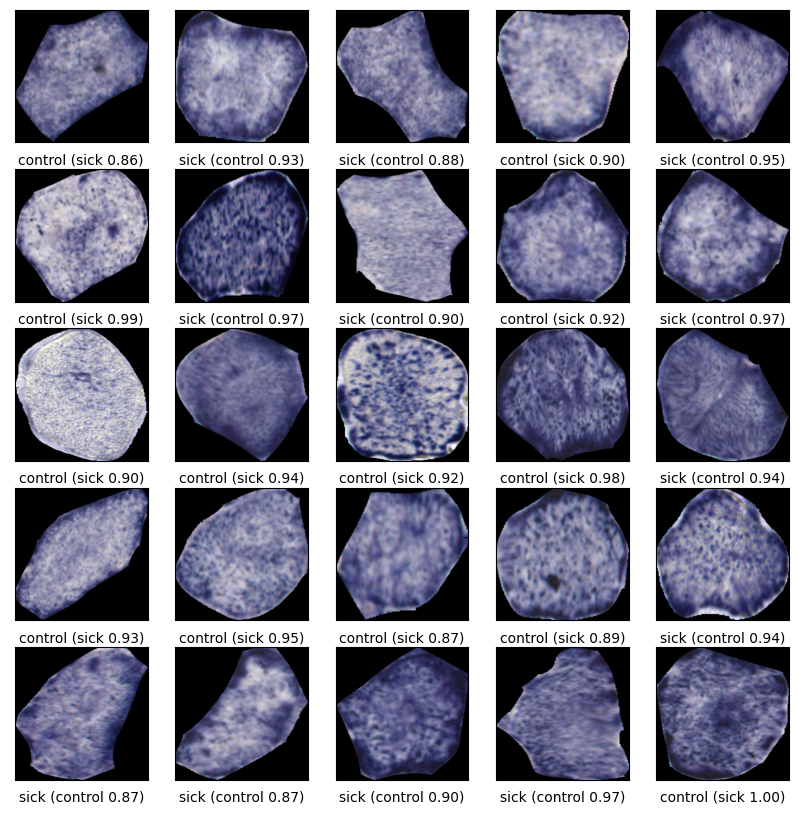

In [56]:
wrong_strong_idx = doubtlab_df[doubtlab_df["long"] == 1.0].index
print(f"Total Number of images with wrong strong classficiation: {len(wrong_strong_idx)} ({round(len(wrong_strong_idx)/len(doubtlab_df)*100, 2)}%)")
SUB_FOLDERS = ["control", "sick"]
counter = 0
plt.figure(figsize=(10,10))
for idx in np.random.choice(wrong_strong_idx, 25, replace=False):
    plt.subplot(5,5,counter+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    im = img_data[idx]
    label = labels[idx]
    plt.imshow(im)

    predict_proba = max(probas[idx])
    predicted_class = np.argmax(probas[idx])    
    plt.xlabel(f"{SUB_FOLDERS[label]} ({SUB_FOLDERS[predicted_class]} {predict_proba:.2f})")
    counter +=1
plt.show()



Total Number of images with wrong: 1004 (5.98%)


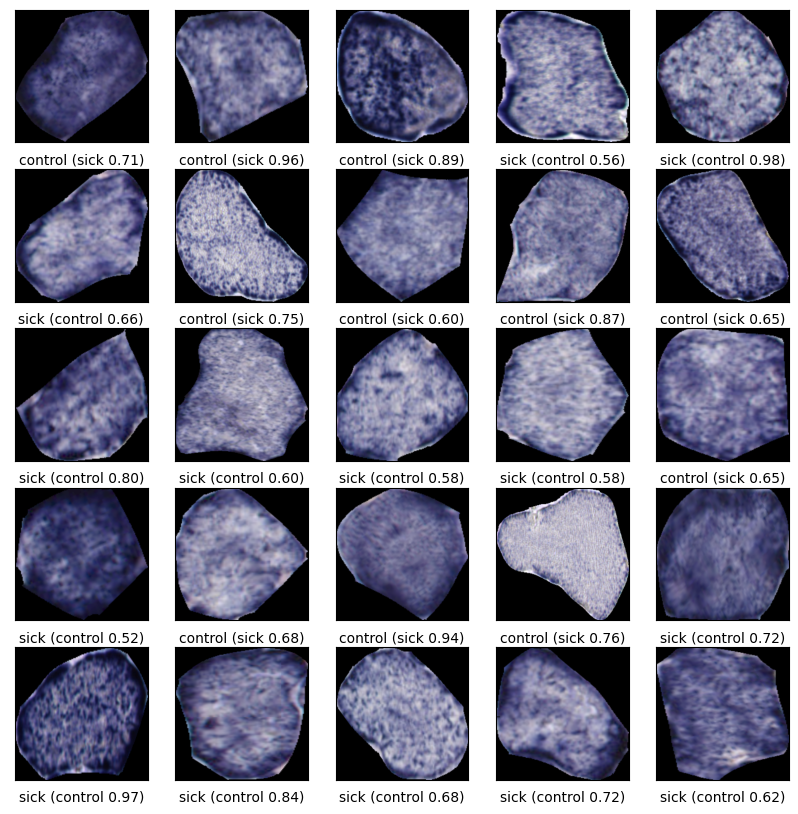

In [59]:
wrong_idx = doubtlab_df[doubtlab_df["wrong"] == 1.0].index
print(f"Total Number of images with wrong: {len(wrong_idx)} ({round(len(wrong_idx)/len(doubtlab_df)*100, 2)}%)")
SUB_FOLDERS = ["control", "sick"]
counter = 0
plt.figure(figsize=(10,10))
for idx in np.random.choice(wrong_idx, 25, replace=False):
    plt.subplot(5,5,counter+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    im = img_data[idx]
    label = labels[idx]
    plt.imshow(im)

    predict_proba = max(probas[idx])
    predicted_class = np.argmax(probas[idx])    
    plt.xlabel(f"{SUB_FOLDERS[label]} ({SUB_FOLDERS[predicted_class]} {predict_proba:.2f})")
    counter +=1
plt.show()



Total Number of images with low probas: 533 (3.18%)


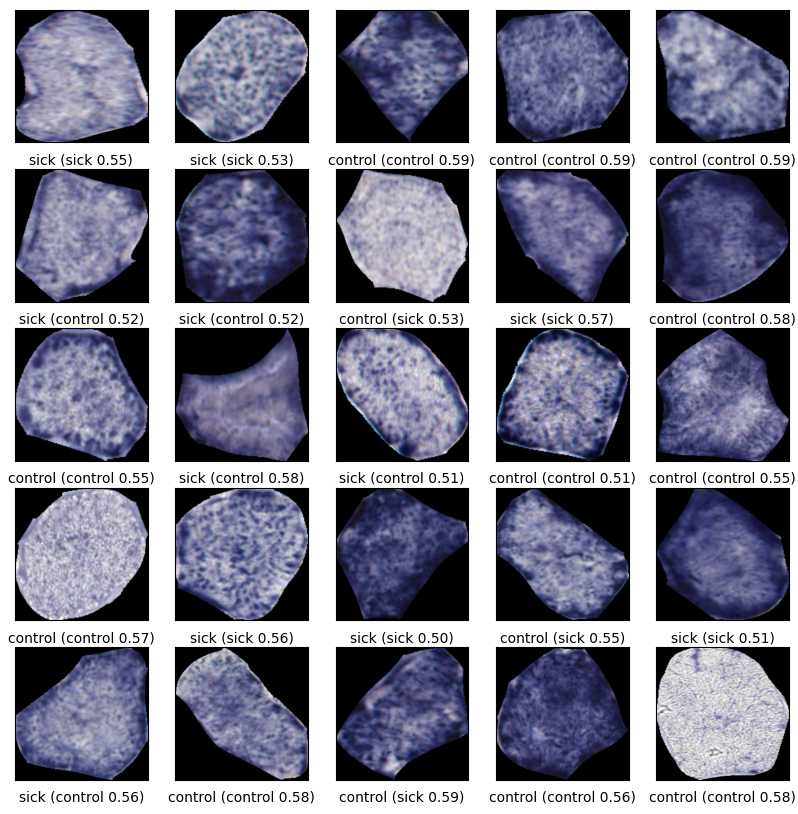

In [60]:
low_idx = doubtlab_df[doubtlab_df["proba"] == 1.0].index
print(f"Total Number of images with low probas: {len(low_idx)} ({round(len(low_idx)/len(doubtlab_df)*100, 2)}%)")
SUB_FOLDERS = ["control", "sick"]
counter = 0
plt.figure(figsize=(10,10))
for idx in np.random.choice(low_idx, 25, replace=False):
    plt.subplot(5,5,counter+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    im = img_data[idx]
    label = labels[idx]
    plt.imshow(im)

    predict_proba = max(probas[idx])
    predicted_class = np.argmax(probas[idx])    
    plt.xlabel(f"{SUB_FOLDERS[label]} ({SUB_FOLDERS[predicted_class]} {predict_proba:.2f})")
    counter +=1
plt.show()



Total Number of images with cleanlab: 248 (1.48%)


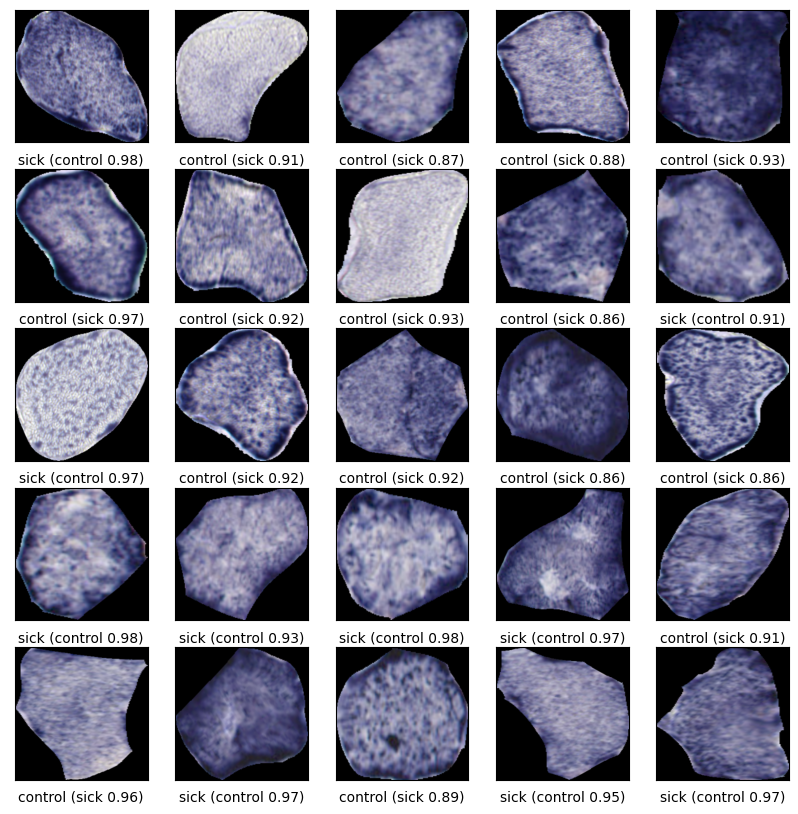

In [61]:
cleanlab_idx = doubtlab_df[doubtlab_df["cleanlab"] == 1.0].index
print(f"Total Number of images with cleanlab: {len(cleanlab_idx)} ({round(len(cleanlab_idx)/len(doubtlab_df)*100, 2)}%)")
SUB_FOLDERS = ["control", "sick"]
counter = 0
plt.figure(figsize=(10,10))
for idx in np.random.choice(cleanlab_idx, 25, replace=False):
    plt.subplot(5,5,counter+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    im = img_data[idx]
    label = labels[idx]
    plt.imshow(im)

    predict_proba = max(probas[idx])
    predicted_class = np.argmax(probas[idx])    
    plt.xlabel(f"{SUB_FOLDERS[label]} ({SUB_FOLDERS[predicted_class]} {predict_proba:.2f})")
    counter +=1
plt.show()



In [71]:
from pigeon import annotate
from PIL import Image
from IPython.display import display
re_annotated_img_files = [ all_files[i] for i in cleanlab_idx ]
annotations = annotate(
  re_annotated_img_files,
  options=["control","sick","unsure"],
  display_fn=lambda filename: display(Image.open(filename, 'r'))
)

HTML(value='0 examples annotated, 249 examples left')

Output()

In [72]:
annotations

[('data/all_images/control/0_294_BIN1_KO_AAV_EMPTY_TAG_SDH - 2022-04-29 22.49.08_1172.tif',
  'sick'),
 ('data/all_images/control/0_CG_SDH_TAM_Dnm2S619L_sl_tam_8_2337.tif',
  'control'),
 ('data/all_images/control/0_CG_SDH_TAM_Dnm2S619L_sl_tam_70_540.tif', 'sick'),
 ('data/all_images/control/0_311_BIN1_KO_AAV_EMPTY_TAG_SDH - 2022-04-29 23.25.56_roi_01_315.tif',
  'unsure'),
 ('data/all_images/control/0_CG_SDH_TAM_Bin1cKO_ko_pla_4_673.tif', 'sick'),
 ('data/all_images/control/0_CG_SDH_TAM_Dnm2S619L_sl_tam_19_204.tif',
  'control'),
 ('data/all_images/control/0_CG_SDH_TAM_Dnm2S619L_sl_tam_8_2330.tif', 'sick')]